# Analyzing Scraped Critic Reviews
### Movie List Project - Notebook #4
### Max Ruther

## Overview

This analysis centers on the individual critic reviews that form the Metacritic aggregate review score, the *Metascore*. Gathered on a film's "Critic Reviews" page on Metacritic are snippets from those pieces as well as the score awarded by the reviewer.

From these pages, I have successfully scraped all such reviews concerning the ~200 films that I've logged as 'watched' in my personal movie database. This yielded ~5900 scraped reviews.

Below, I combine the scraped review scores of the various publications with those of my own, then perform exploratory analysis.

## Motivation

This scraping effort and the following analysis were largely motivated by findings from preceding analyses. Those culminated to binary classification of my film enjoyment (like or dislike) through Decision Trees trained on ratings data, like the *Metascore* and other online aggregates. 

I there found that the classification was primarily dictated by the films' *Metascore* ratings. It seemed that little additional information was presented by the other online aggregate scores, which were from *IMDb* and *Rotten Tomatoes*.

To nuance my understanding of this top predictor, the *Metascore*, I here attempt to drill down on it. I do so by analyzing its constituent ratings, which come from various publications external to Metacritic.

## Setup

##### Imports

In [1]:
import pandas as pd
import numpy as np

import pymysql
from sqlalchemy import create_engine

import os

from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

##### Seed for Randomization

In [2]:
rand_st = 44

##### Connect the SQLAlchemy engine to my local MySQL movie database

In [3]:
# Connect to the MySQL db
movie_db_url = None
with open('../.secret/movie_db_url.txt', 'r') as f:
    movie_db_url = f.read().strip()
engine = create_engine(movie_db_url)
conn = engine.connect()

### Load in the scraped critic review data

I here load in the individual critic reviews that I scraped from Metacritic. Metacritic aggregates these reviews, but they originally come from many various, external publications.

In [4]:
mc_review_query = """
SELECT * FROM my_watched_films_mc_reviews
"""

mcr_df = pd.read_sql_query(mc_review_query, engine)
mcr_df.head()

,Title Searched,Year Searched,Director Searched,Publication,Score,Critic,Snippet,Date Written
0,If Beale Street Could Talk,2018,Barry Jenkins,The Playlist,100,Jason Bailey,"Jenkins captures the humor, verve, and conside...",2018-09-09
1,If Beale Street Could Talk,2018,Barry Jenkins,Screen Daily,100,Tim Grierson,If Beale Street isn’t quite as seamless as the...,2018-09-09
2,If Beale Street Could Talk,2018,Barry Jenkins,Vanity Fair,100,K. Austin Collins,What Jenkins gets most right—what astonishes m...,2018-09-10
3,If Beale Street Could Talk,2018,Barry Jenkins,Los Angeles Times,100,Justin Chang,"In cutting against the aesthetic grain, Jenkin...",2018-09-10
4,If Beale Street Could Talk,2018,Barry Jenkins,Consequence,100,Sarah Kurchak,"Weaving together the past and the present, mas...",2018-09-11


In [5]:
# # Constructing the relative filepath of the scraped review .csv
# curr_dir = os.getcwd()
# mc_cr_data_filepath = os.path.join(curr_dir, '..', 'data', 'scraped', 'mc_cr.csv')
# mc_cr_data_filepath

In [6]:
# # Reading in the data from that filepath
# mcr_df = pd.read_csv(mc_cr_data_filepath)
# mcr_df.head()

#### Quick EDA: Scraped Reviews

Before I proceed to load in my own review scores and start to integrate them with the above scraped ones, I am going to do some light exploration of this dataset on its own.

As a reminder of what this dataset signifies: these are records of all "Critic Reviews" collected by Metacritic to form their *Metascore*, but only those relating to my watched films from my personal movie database. There are roughly 250 watched films, at this time.

##### Review Counts by Publication

In [7]:
rev_counts_by_pub = mcr_df['Publication'].value_counts()

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(rev_counts_by_pub)

Top 10 publications by review count:

In [8]:
rev_counts_by_pub.head(10)

Publication
Washington Post                 195
The New York Times              192
Variety                         189
Los Angeles Times               182
Austin Chronicle                163
Empire                          153
The A.V. Club                   150
The Guardian                    145
San Francisco Chronicle         141
The Globe and Mail (Toronto)    141
Name: count, dtype: int64

Bottom 10 publications by review count:

In [9]:
rev_counts_by_pub.tail(10)

Publication
Boxoffice Magazine                4
The Dissolve                      4
TNT RoughCut                      4
Looper                            4
The Times                         4
Film Journal International        4
McClatchy-Tribune News Service    3
MTV News                          3
Hitfix                            3
Movieline                         3
Name: count, dtype: int64

Descriptive statistics on these review counts by publication: 

In [10]:
rev_counts_by_pub.describe()

count    106.000000
mean      64.320755
std       50.115210
min        3.000000
25%       19.750000
50%       57.000000
75%       98.500000
max      195.000000
Name: count, dtype: float64

Obsolete discussion requiring update <!-- On average, a publication has reviewed 55.41 of my watched films. The interquartile range suggests that the most central half of review counts by publication range from 18 to 81. -->

##### Count of Films Present in this Scraped Dataset

This count might not include all the films from my database's 'watched' table, because Metacritic sometimes lacks critical reviews or Metascores.

In [11]:
key_attrs = ['Title Searched', 'Year Searched', 'Director Searched']

In [12]:
len(mcr_df.groupby(key_attrs))

211

Obsolete discussion requiring update <!-- 180 films are represented in these scraped reviews. -->

##### Review Count by Film

In [13]:
rev_counts_by_film = mcr_df[key_attrs].value_counts()
rev_counts_by_film

Title Searched                             Year Searched  Director Searched
Furiosa: A Mad Max Saga                    2024           George Miller        50
Three Billboards Outside Ebbing, Missouri  2017           Martin McDonagh      50
Challengers                                2024           Luca Guadagnino      50
Civil War                                  2024           Alex Garland         50
Conclave                                   2024           Edward Berger        50
                                                                               ..
The Boondock Saints                        1999           Troy Duffy            4
The Artifice Girl                          2022           Franklin Ritch        4
Troll 2                                    1990           Claudio Fragasso      2
Inspector Ike                              2020           Graham Mason          2
Rampant                                    2018           Kim Sung-hoon         1
Name: count, Length: 2

At the top, there are five movies shown as having 50 reviews. Checking to see how many films have that many, and how the counts distribute more generally:

In [14]:
rev_counts_by_film.value_counts().sort_index(ascending=False)

count
50    41
49     1
48     7
47     1
46     7
45     1
44     4
43     5
42     4
41     1
40     5
39     3
38     6
37     6
36     7
35     4
34     4
33     3
32     3
31     6
30     7
29     3
28     2
27     5
26     2
25     2
24     5
23     4
22     2
21     2
20     8
19     4
18     4
17     7
16     4
15     5
14     2
13     6
12     1
11     2
10     3
9      4
8      1
7      1
5      1
4      2
2      2
1      1
Name: count, dtype: int64

Of the various review counts, films most often have 50. Descriptive statistics are necessary to better understand this distribution.

Descriptive Statistics on review count by film:

In [15]:
rev_counts_by_film.describe()

count    211.000000
mean      32.312796
std       14.112702
min        1.000000
25%       20.000000
50%       34.000000
75%       46.000000
max       50.000000
Name: count, dtype: float64

Obsolete discussion needs editing <!-- On average, films are associated with `32.63` reviews. The interquartile range spans from `20` to `48` reviews. This ranges upper limit is close to the maximum review count per film, `50`. -->

### Load in the data of my own film ratings

Next, I load in my own ratings of these films, querying them from my MySQL movie database.

In [16]:
query = "SELECT Title, Year, Rating FROM allwatched"
aw_df = pd.read_sql_query(query, engine)

aw_df.head()

,Title,Year,Rating
0,If Beale Street Could Talk,2018,AWESOME
1,Mad Max: Fury Road,2015,AWESOME
2,Babygirl,2024,NOT FOR ME
3,Inside the Yellow Cocoon Shell,2023,PRETTY AWESOME
4,Nosferatu,2024,PRETTY AWESOME


## Transformation

I would like to form a dataset that shows my review scores alongside those of the individual publications. For such integration, I first need to  complete the following tasks of data transformation:
- **Scraped Critic Reviews**:
  - Create *Title* and *Year* fields to match those in the other dataset, from the existing *Film* attribute. I will join the two datasets on these.
  - Transform the range of the review scores from integers between 0 and 100 to decimals between 0 and 1.
- **My Ratings**:
  - Add a *Publication* attribute to match that of the other dataset. In this dataset, this attribute's values will be set to my name, uniformly. (As if I am the "publication.")
  - Remap my categorical ratings to decimal ones, between 0 and 1.
  - Amend some misentered *Title* values

### Scraped Critic Reviews

#### Create *Title* and *Year* attributes from *Film*

In [17]:
mcr_df = mcr_df.rename(columns={'Title Searched': 'Title', 'Year Searched': 'Year'})
mcr_df.head(3)

,Title,Year,Director Searched,Publication,Score,Critic,Snippet,Date Written
0,If Beale Street Could Talk,2018,Barry Jenkins,The Playlist,100,Jason Bailey,"Jenkins captures the humor, verve, and conside...",2018-09-09
1,If Beale Street Could Talk,2018,Barry Jenkins,Screen Daily,100,Tim Grierson,If Beale Street isn’t quite as seamless as the...,2018-09-09
2,If Beale Street Could Talk,2018,Barry Jenkins,Vanity Fair,100,K. Austin Collins,What Jenkins gets most right—what astonishes m...,2018-09-10


In [18]:
# mcr_df[['Title', 'Year']] = mcr_df['Film'].str.extract(r'(^.*) \(([0-9]{4})\)$')
# mcr_df[['Film','Title','Year']].head()

#### Transform *Score* to decimal in [0, 1]

In [19]:
mcr_score_df = mcr_df[['Title','Year','Publication','Score']]
mcr_score_df.head(3)

,Title,Year,Publication,Score
0,If Beale Street Could Talk,2018,The Playlist,100
1,If Beale Street Could Talk,2018,Screen Daily,100
2,If Beale Street Could Talk,2018,Vanity Fair,100


In [20]:
mcr_score_df.loc[:, 'Score'] = mcr_df.loc[:, 'Score'].astype(float)
mcr_score_df.loc[:, 'Score'] = mcr_score_df.loc[:, 'Score'].div(float(100))

mcr_score_df.head(3)

C:\Users\maxru\AppData\Local\Temp\ipykernel_50844\3791278146.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.  1.  1.  ... 0.5 0.5 0.4]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  mcr_score_df.loc[:, 'Score'] = mcr_score_df.loc[:, 'Score'].div(float(100))


,Title,Year,Publication,Score
0,If Beale Street Could Talk,2018,The Playlist,1.0
1,If Beale Street Could Talk,2018,Screen Daily,1.0
2,If Beale Street Could Talk,2018,Vanity Fair,1.0


#### NON-FACTOR NOW? - Replace character `’` with `'`

The scraped reviews often use the `’` apostrophe to title films, which differs from the titling in my own ratings data, and so presents a consequential descrepancy.

In [21]:
mcr_score_df[mcr_score_df['Title'].str.contains("’")][['Title', 'Year']].drop_duplicates()

,Title,Year


In [22]:
mcr_score_df.loc[:, 'Title'] = mcr_score_df.loc[:, 'Title'].str.replace('’', "'")
mcr_score_df[mcr_score_df['Title'].str.contains("'")][['Title', 'Year']].drop_duplicates()

,Title,Year
1540,The Teachers' Lounge,2023
2704,The People's Joker,2022
5221,Howl's Moving Castle,2004
5871,A Knight's Tale,2001


### My Ratings

#### Add _Publication_ attribute

I am adding this attribute to match that in the other dataset, to ease an eventual merge. 

I'm setting my name as this attribute's value for all entries in this table.

In [23]:
aw_df['Publication'] = 'Max Ruther'
aw_df.head()

# aw_score_df = aw_df[['Title','Year','Publication','Score']]
# aw_score_df.head()

,Title,Year,Rating,Publication
0,If Beale Street Could Talk,2018,AWESOME,Max Ruther
1,Mad Max: Fury Road,2015,AWESOME,Max Ruther
2,Babygirl,2024,NOT FOR ME,Max Ruther
3,Inside the Yellow Cocoon Shell,2023,PRETTY AWESOME,Max Ruther
4,Nosferatu,2024,PRETTY AWESOME,Max Ruther


#### Remap my _Rating_ to numeric scores

I like to rate my watches with categorical values, but I consider them equivalent to the following decimal ratings (between `0` and `1`.)

In [24]:
my_rating_to_score = {
    'NOT FOR ME' : 0,        # 0 / 4 stars
    'GREAT': 0.625,          # 2.5 / 4 stars
    'PRETTY AWESOME': 0.875, # 3.5 / 4 stars
    'AWESOME': 1,            # 4 / 4 stars
}

In [25]:
aw_df['Score'] = aw_df['Rating'].map(my_rating_to_score)
aw_df.head()

,Title,Year,Rating,Publication,Score
0,If Beale Street Could Talk,2018,AWESOME,Max Ruther,1.000
1,Mad Max: Fury Road,2015,AWESOME,Max Ruther,1.000
2,Babygirl,2024,NOT FOR ME,Max Ruther,0.000
3,Inside the Yellow Cocoon Shell,2023,PRETTY AWESOME,Max Ruther,0.875
4,Nosferatu,2024,PRETTY AWESOME,Max Ruther,0.875


#### Leave out unmapped *Rating* field

Excluding the *Rating* attribute to form the final "My Ratings" dataset for integration.

In [26]:
aw_score_df = aw_df.drop(columns='Rating')
aw_score_df.head()

,Title,Year,Publication,Score
0,If Beale Street Could Talk,2018,Max Ruther,1.000
1,Mad Max: Fury Road,2015,Max Ruther,1.000
2,Babygirl,2024,Max Ruther,0.000
3,Inside the Yellow Cocoon Shell,2023,Max Ruther,0.875
4,Nosferatu,2024,Max Ruther,0.875


#### Address an Issue: *Title* Discrepancies

Some titles from my own ratings data differ from those in the scraped review data (despite representing the same film.) I here spotfix such cases with a remapping:

In [27]:
# title_fix_mapping = {
#     "Adaptation": "Adaptation.",
#     "Dragonheart": "DragonHeart",
#     "Gone in 60 Seconds": "Gone in Sixty Seconds",
#     "Goodfellas": "GoodFellas",
#     "Pokemon Detective Pikachu": "Pokémon Detective Pikachu",
#     "Pokemon: The First Movie": "Pokémon: The First Movie",
#     "Sorry To Bother You": "Sorry to Bother You",
#     "TÃ¡r": "TÁR"
# }

In [28]:
# aw_score_df.loc[:, 'Title'] = aw_score_df.loc[:, 'Title'].replace(title_fix_mapping)

## Integration

Now that the two datasets have been transformed to be more alike, I can combine them through concatenation. This will result in a table where each row represents a review score for a film as given by either a publication or myself.

From there, I pivot the table wider to form a table where:
- Films are uniquely represented by row.
- The various *Publication* values are each attributes instead, where their values are the review score given.


### Combining my ratings with the publications'

I'm doing so through concatenation.

In [29]:
acr_df = pd.concat([aw_score_df, mcr_score_df], ignore_index=True)

In [30]:
# To conveniently illustrate the successful combination of these records, I show 
# those of a film that I've elsewhere identified as having exactly 5 review 
# scores (including my own.)

acr_df[acr_df['Title'] == 'The Artifice Girl']

,Title,Year,Publication,Score
57,The Artifice Girl,2022,Max Ruther,0.875
1984,The Artifice Girl,2022,RogerEbert.com,0.750
1985,The Artifice Girl,2022,Screen Rant,0.700
1986,The Artifice Girl,2022,Paste Magazine,0.590
1987,The Artifice Girl,2022,Los Angeles Times,0.500


#### An Issue Preventing Pivoting: Duplicates

These are instances where multiple critics from the same publication reviewed the same movie. This blocks me from pivoting the table wider to my desired end result, which is a table where every row uniquely represents a film and there is only one score given by each publication. 

First, I identify duplicate instances of *Title*, *Year*, and *Publication*.

In [31]:
dup_film_and_publ_df = acr_df[acr_df.duplicated(['Title', 'Year', 'Publication'], keep=False)]
dup_film_and_publ_df.head(8)
# acr_df[acr_df.duplicated(['Title', 'Year', 'Publication'], keep=False)][['Title','Year','Publication']].value_counts()
# acr_df[acr_df.duplicated(['Title', 'Year', 'Publication'], keep=False)].tail(8)

,Title,Year,Publication,Score
250,If Beale Street Could Talk,2018,The Guardian,0.80
258,If Beale Street Could Talk,2018,The Guardian,0.80
317,Babygirl,2024,The Daily Beast,1.00
333,Babygirl,2024,The Daily Beast,0.88
472,Saltburn,2023,Los Angeles Times,0.80
509,Saltburn,2023,Los Angeles Times,0.40
562,Adaptation,2002,Washington Post,1.00
567,Adaptation,2002,Washington Post,1.00


Counting the duplicated instances of *Title*, *Year*, and *Publication*:

In [32]:
dup_film_and_publ_df[['Title','Year','Publication']].drop_duplicates().shape[0]

100

For each such duplicated set of values, counting the associated review scores:

In [33]:
review_count_by_film_and_publ = dup_film_and_publ_df[['Title','Year','Publication']]\
.value_counts()\
.rename('Count').reset_index()\
.sort_values(by='Count', ascending=False)

review_count_by_film_and_publ

,Title,Year,Publication,Count
0,Eyes Wide Shut,1999,Film.com,3
1,Gladiator,2000,Film.com,3
63,Bedazzled,2000,Washington Post,2
73,Adaptation,2002,Washington Post,2
72,American Fiction,2023,The Guardian,2
...,...,...,...,...
30,TÃ¡r,2022,New York Magazine (Vulture),2
29,Under the Skin,2013,CineVue,2
28,Under the Skin,2013,The Guardian,2
27,The Santa Clause,1994,Washington Post,2


In [34]:
review_count_by_film_and_publ['Count'].value_counts()

Count
2    98
3     2
Name: count, dtype: int64

#### Handling the duplicates: Averaging

To handle cases where there a publication provides multiple review scores for a film, I average those.

Taking the duplicates aside and averaging their scores to create one record per *Title*, *Year*, and *Publication*:

In [35]:
# avgd_dups = acr_df[acr_df.duplicated(['Title', 'Year', 'Publication'], keep=False)]\
avgd_dups = dup_film_and_publ_df\
.groupby(['Title', 'Year', 'Publication'], as_index=False)\
.mean('Score')

avgd_dups.head()

,Title,Year,Publication,Score
0,A Knight's Tale,2001,Washington Post,0.75
1,A Real Pain,2024,Los Angeles Times,0.90
2,Adaptation,2002,Film Threat,0.70
3,Adaptation,2002,Washington Post,1.00
4,American Fiction,2023,The Guardian,0.80


From the unduplicated records, forming a separate df for imminent combination:

In [36]:
undupd = acr_df.drop_duplicates(['Title', 'Year', 'Publication'], keep=False)
undupd.head()

,Title,Year,Publication,Score
0,If Beale Street Could Talk,2018,Max Ruther,1.000
1,Mad Max: Fury Road,2015,Max Ruther,1.000
2,Babygirl,2024,Max Ruther,0.000
3,Inside the Yellow Cocoon Shell,2023,Max Ruther,0.875
4,Nosferatu,2024,Max Ruther,0.875


Combining these sets through concatenation to create a deduplicated one.

In [37]:
acr_dedupd = pd.concat([avgd_dups, undupd], axis=0).sort_values(by='Title', ascending=False)
# acr_dedupd[acr_dedupd['Title']=='You Hurt My Feelings']

With these fields now deduplicated, I can pivot wider on their basis, as initially planned:

In [38]:
acr_df2 = acr_dedupd.pivot(index=['Title', 'Year'], columns='Publication', values='Score')
# acr_df2 = acr_dedupd.pivot(index=['Title', 'Year'], columns='Publication', values='Score').reset_index()
# acr_df2.columns.name = None
acr_df2.head()
# acr_df2[['Washington Post', 'Max Ruther']].head(10)
# acr_df2.reset_index()
# print(acr_df2.columns)

,Publication,ABC News,Arizona Republic,Austin Chronicle,BBC,Baltimore Sun,Boston Globe,Boxoffice Magazine,CNN,Charlotte Observer,Chicago Reader,...,USA Today,Uproxx,Vanity Fair,Variety,Village Voice,Vox,Wall Street Journal,Washington Post,We Got This Covered,i
Title,Year,,,,,,,,,,,,,,,,,,,,,
7 Days,2021,NaN,NaN,0.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.7,NaN,NaN,NaN,NaN,NaN,NaN
A Knight's Tale,2001,NaN,NaN,0.67,NaN,0.38,0.75,NaN,NaN,NaN,0.6,...,0.50,NaN,NaN,0.3,0.4,NaN,0.7,0.75,NaN,NaN
A Real Pain,2024,0.88,1.0,0.78,NaN,NaN,0.88,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.00,1.0,NaN
Adaptation,2002,NaN,NaN,0.89,NaN,0.75,1.00,NaN,NaN,0.5,0.7,...,0.63,NaN,NaN,0.9,0.9,NaN,0.8,1.00,NaN,NaN
Aftersun,2022,0.90,NaN,0.78,NaN,NaN,1.00,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,0.9,NaN,NaN,NaN,0.75,1.0,NaN


Alternate pivoted df, with indeces and column name all reset:

In [39]:
acr_df3 = acr_dedupd.pivot(index=['Title', 'Year'], columns='Publication', values='Score').reset_index()
acr_df3.columns.name = None
acr_df3.head()

,Title,Year,ABC News,Arizona Republic,Austin Chronicle,BBC,Baltimore Sun,Boston Globe,Boxoffice Magazine,CNN,...,USA Today,Uproxx,Vanity Fair,Variety,Village Voice,Vox,Wall Street Journal,Washington Post,We Got This Covered,i
0,7 Days,2021,NaN,NaN,0.67,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.7,NaN,NaN,NaN,NaN,NaN,NaN
1,A Knight's Tale,2001,NaN,NaN,0.67,NaN,0.38,0.75,NaN,NaN,...,0.50,NaN,NaN,0.3,0.4,NaN,0.7,0.75,NaN,NaN
2,A Real Pain,2024,0.88,1.0,0.78,NaN,NaN,0.88,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.00,1.0,NaN
3,Adaptation,2002,NaN,NaN,0.89,NaN,0.75,1.00,NaN,NaN,...,0.63,NaN,NaN,0.9,0.9,NaN,0.8,1.00,NaN,NaN
4,Aftersun,2022,0.90,NaN,0.78,NaN,NaN,1.00,NaN,NaN,...,NaN,NaN,1.0,0.9,NaN,NaN,NaN,0.75,1.0,NaN


## EDA

### Review score counts per movie

To create a series of review counts per movie, I calculate the sum of non-missing (review) values in each (movie) row:

In [40]:
rev_counts_per_movie = acr_df2.notna().sum(axis=1).sort_values(ascending=False)
rev_counts_per_movie.head()

Title                                    Year
The Banshees of Inisherin                2022    51
Barbie                                   2023    51
The Zone of Interest                     2023    51
The Unbearable Weight of Massive Talent  2022    51
M3GAN                                    2022    51
dtype: int64

I transform this multi-index series to a dataframe, to ease some imminent visualization:

In [41]:
revc_by_mov_df = rev_counts_per_movie.reset_index()
revc_by_mov_df.columns = ['Title', 'Year', 'Review Count']
revc_by_mov_df = revc_by_mov_df.sort_values(by=['Review Count', 'Title'], ascending=[True, True])

In [42]:
revc_by_mov_df[revc_by_mov_df['Title'] == 'Adaptation']

,Title,Year,Review Count
77,Adaptation,2002,39


#### Tipping Point for Review Count by film?

Something I've wondered in my experience of browsing *Metacritic* is whether there might be a "tipping point" for reviews for a film, past which reviews start to flood in from all the publications. I am thinking of a phenomenon where a movie picks up enough "buzz" and then might catch the attention of most reviewers.

To check this out, I plot the review counts by film to see if there might be a threshold of review count at which reviews sharply increase. This isn't a time series of a single movie, but 

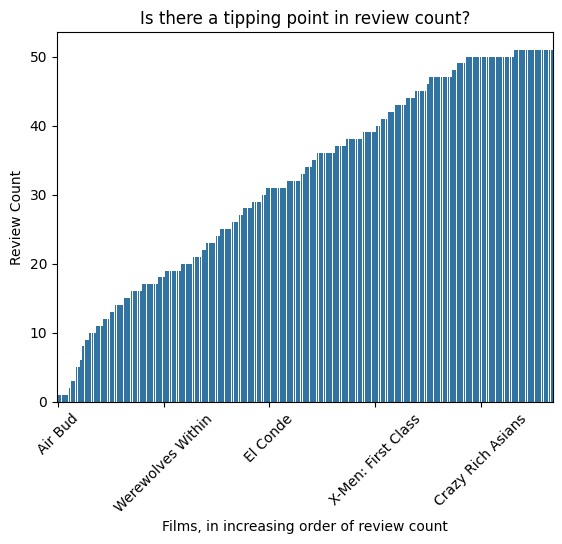

In [43]:
ax = sns.barplot(x='Title', y='Review Count', data=revc_by_mov_df)

ax.set(title="Is there a tipping point in review count?")
ax.set(ylabel="Review Count")
ax.set(xlabel="Films, in increasing order of review count")

# ax.set(xticklabels=[])
# ax.tick_params(bottom=False)



xticklabels = ax.get_xticklabels()

new_xticks = ax.get_xticks()[::46]
new_xticklabels = [xticklabels[i] for i in range(0, len(xticklabels), 46)]

ax.set_xticks(new_xticks)
ax.set_xticklabels(new_xticklabels)

plt.xticks(rotation=45)

plt.show()

It appears that, at least for the films that I've watched in the past few years, there might be a steep incline for review counts that fall within `1` and `10`. But otherwise, the distribution looks pretty linear as it climbs. This doesn't not suggest a tipping point like I had wondered about.

If I were to continue in this vein, I would incorporate the *Release Date* attribute into this data, which is consistently populated in my personal movie database.

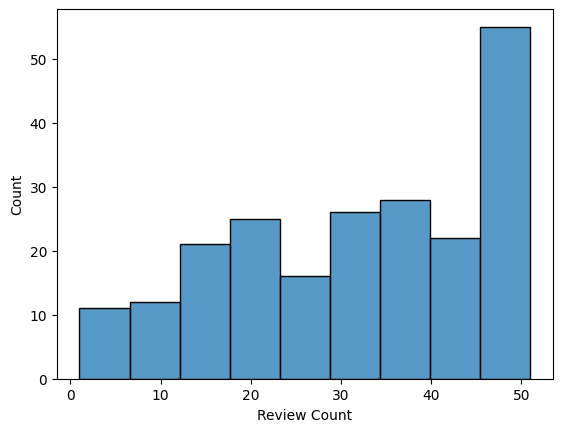

In [44]:
sns.histplot(data=revc_by_mov_df, x='Review Count')
plt.show()

In [46]:
rev_count_per_pub = acr_df2.notna().sum(axis=0).sort_values(ascending=False)
rev_count_per_pub.head(10)

Publication
Max Ruther                      216
The New York Times              192
Variety                         189
Los Angeles Times               179
Washington Post                 165
Austin Chronicle                163
Empire                          152
The A.V. Club                   147
San Francisco Chronicle         141
The Globe and Mail (Toronto)    139
dtype: int64

### Correlations between my ratings and the publications'

First, I generate and print all of the correlations.

In [47]:
pub_corrs = acr_df2.corr()['Max Ruther'].sort_values(ascending=False).rename('Corr to Max')

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(pub_corrs)

Publication
The Times                         1.000000
Max Ruther                        1.000000
MTV News                          1.000000
Film Journal International        0.994389
The Verge                         0.904010
TNT RoughCut                      0.802955
Boxoffice Magazine                0.774597
Philadelphia Daily News           0.739749
i                                 0.612372
Looper                            0.609088
Dallas Observer                   0.605123
NPR                               0.574516
St. Louis Post-Dispatch           0.572552
Uproxx                            0.570780
CNN                               0.533871
USA Today                         0.530030
Tampa Bay Times                   0.516361
Movieline                         0.500000
Hitfix                            0.500000
McClatchy-Tribune News Service    0.500000
The Globe and Mail (Toronto)      0.493331
Philadelphia Inquirer             0.490109
San Francisco Chronicle           0.468849

I am recognizing a few of the higher correlates as infrequent reviewers. I'm most interested in the more regular reviewers' correlations.

To filter accordingly, I join the publications' review counts to the above correlation table, then conditionally select rows that meet a specificed minimum review count:

In [48]:
pub_corr_n_cnts = pd.merge(pub_corrs, rev_count_per_pub.rename('Review Count'), on='Publication')

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(pub_corr_n_cnts[pub_corr_n_cnts['Review Count']>80])

                              Corr to Max  Review Count
Publication                                            
Max Ruther                       1.000000           216
USA Today                        0.530030            84
The Globe and Mail (Toronto)     0.493331           139
San Francisco Chronicle          0.468849           141
The New York Times               0.467828           192
Washington Post                  0.460872           165
Los Angeles Times                0.451804           179
Empire                           0.447653           152
Austin Chronicle                 0.440429           163
Entertainment Weekly             0.436092           118
Chicago Tribune                  0.435577           137
Chicago Sun-Times                0.401946           136
Film Threat                      0.392496            85
Variety                          0.391147           189
The A.V. Club                    0.347952           147
Time Out                         0.343648       

### Films that lack representation in the Metacritic CR data

In [49]:
films_lacking_mcr_scrape = list(rev_counts_per_movie[rev_counts_per_movie==1].index)
films_lacking_mcr_scrape

[('Memories', '1995'),
 ('Nate - A One Man Show', '2020'),
 ('Gone in 60 Seconds', '2000'),
 ('Pokemon 2000', '2000'),
 ('Air Bud', '1997')]

## More

In [51]:
acr_df3.notna()

,Title,Year,ABC News,Arizona Republic,Austin Chronicle,BBC,Baltimore Sun,Boston Globe,Boxoffice Magazine,CNN,...,USA Today,Uproxx,Vanity Fair,Variety,Village Voice,Vox,Wall Street Journal,Washington Post,We Got This Covered,i
0,True,True,False,False,True,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
1,True,True,False,False,True,False,True,True,False,False,...,True,False,False,True,True,False,True,True,False,False
2,True,True,True,True,True,False,False,True,False,False,...,False,False,False,True,False,False,False,True,True,False
3,True,True,False,False,True,False,True,True,False,False,...,True,False,False,True,True,False,True,True,False,False
4,True,True,True,False,True,False,False,True,False,False,...,False,False,True,True,False,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,True,True,False,False,True,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
212,True,True,False,True,True,False,False,True,True,False,...,True,False,False,True,True,False,True,True,False,False
213,True,True,True,False,True,False,False,True,False,False,...,False,False,True,True,False,False,True,True,True,False
214,True,True,False,True,True,False,False,True,False,False,...,False,False,False,True,True,True,False,True,False,False


In [81]:
acr_df3[list(rev_counts_by_pub.head(10).index)].notna().value_counts().head(20)

Washington Post  The New York Times  Variety  Los Angeles Times  Austin Chronicle  Empire  The A.V. Club  The Guardian  San Francisco Chronicle  The Globe and Mail (Toronto)
True             True                True     True               True              True    True           True          True                     True                            37
                                                                                                          False         True                     True                            21
                                                                                   False   True           False         True                     True                             9
                                                                                   True    True           True          False                    False                            8
                                                                                                          

In [82]:
from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [106]:
# top_rev_attrs = list(rev_counts_by_pub.head(10).index)
top_rev_attrs = list(rev_counts_by_pub.head(10).index) + ['The Guardian']
top_rev_attrs

['Washington Post',
 'The New York Times',
 'Variety',
 'Los Angeles Times',
 'Austin Chronicle',
 'Empire',
 'The A.V. Club',
 'The Guardian',
 'San Francisco Chronicle',
 'The Globe and Mail (Toronto)',
 'The Guardian']

In [107]:
acr_df3['The New York Times'].dropna().shape[0]

192

In [108]:
revfreq_dict_list = []
for i in powerset(top_rev_attrs):
    # Skip the empty set
    if not i:
        continue
        
    attrs = list(i)
    attr_set = ', '.join(attrs)
    attr_count = len(attrs)
    row_count = acr_df3[attrs].dropna().shape[0]

    revfreq_dict = {
        'attr_set': attr_set,
        'attr_count': attr_count,
        'row_count': row_count,
    }
    revfreq_dict_list.append(revfreq_dict)
    
    # print(attr_set,
    #       attr_count,
    #       row_count,
    #       sep='\t',
    #      )

revfreq_df = pd.DataFrame(revfreq_dict_list)

In [109]:
revfreq_df.sort_values(by='row_count', ascending=False).head(30)

,attr_set,attr_count,row_count
1,The New York Times,1,192
2,Variety,1,189
3,Los Angeles Times,1,179
21,"The New York Times, Variety",2,173
0,Washington Post,1,165
22,"The New York Times, Los Angeles Times",2,165
30,"Variety, Los Angeles Times",2,163
4,Austin Chronicle,1,163
11,"Washington Post, The New York Times",2,155
12,"Washington Post, Variety",2,154


In [110]:
revfreq_df.groupby('attr_count').max('row_count').reset_index()

,attr_count,row_count
0,1,192
1,2,173
2,3,150
3,4,132
4,5,119
5,6,99
6,7,82
7,8,69
8,9,58
9,10,44


In [111]:
with pd.option_context('display.max_colwidth', None):
    print(pd.merge(revfreq_df, revfreq_df.groupby('attr_count').max('row_count').reset_index(), on=['attr_count', 'row_count']))

                                                                                                                                                                                       attr_set  \
0                                                                                                                                                                            The New York Times   
1                                                                                                                                                                   The New York Times, Variety   
2                                                                                                                                                The New York Times, Variety, Los Angeles Times   
3                                                                                                                               Washington Post, The New York Times, Variety, Los Angeles Times   
4                        

In [128]:
def biggest_misses(
    chosen_set_str,
    top_n=30
):
    chosen_set = chosen_set_str.split(', ')
    print(chosen_set)
    
    return acr_df3.drop(acr_df3[chosen_set].dropna().index)[['Title', 'Max Ruther']].sort_values(by='Max Ruther', ascending=False).head(30)

In [129]:
biggest_misses('Washington Post, The New York Times, Variety, Los Angeles Times')

['Washington Post', 'The New York Times', 'Variety', 'Los Angeles Times']


,Title,Max Ruther
178,The Holdovers,1.000
44,Dinner in America,1.000
113,Nate - A One Man Show,1.000
61,Furiosa: A Mad Max Saga,1.000
105,May December,1.000
195,The Teachers' Lounge,1.000
20,Barbie,0.875
148,Shiva Baby,0.875
112,Morvern Callar,0.875
156,Small Things Like These,0.875


In [130]:
biggest_misses('The New York Times, Variety, Los Angeles Times')

['The New York Times', 'Variety', 'Los Angeles Times']


,Title,Max Ruther
61,Furiosa: A Mad Max Saga,1.000
178,The Holdovers,1.000
195,The Teachers' Lounge,1.000
44,Dinner in America,1.000
113,Nate - A One Man Show,1.000
144,Saltburn,0.875
199,The Zone of Interest,0.875
116,Nomadland,0.875
189,The People's Joker,0.875
117,Nosferatu,0.875


In [132]:
biggest_misses('The New York Times, Variety')

['The New York Times', 'Variety']


,Title,Max Ruther
113,Nate - A One Man Show,1.000
195,The Teachers' Lounge,1.000
61,Furiosa: A Mad Max Saga,1.000
116,Nomadland,0.875
112,Morvern Callar,0.875
117,Nosferatu,0.875
158,Sorry To Bother You,0.875
189,The People's Joker,0.875
67,Goodfellas,0.875
199,The Zone of Interest,0.875


In [133]:
biggest_misses('The New York Times')

['The New York Times']


,Title,Max Ruther
113,Nate - A One Man Show,1.000
199,The Zone of Interest,0.875
53,Emily the Criminal,0.875
67,Goodfellas,0.875
116,Nomadland,0.875
20,Barbie,0.875
144,Saltburn,0.875
173,The Artifice Girl,0.875
43,Demolition Man,0.625
197,The Wonderful Story of Henry Sugar,0.625


In [134]:
biggest_misses('Washington Post, Variety, Los Angeles Times')

['Washington Post', 'Variety', 'Los Angeles Times']


,Title,Max Ruther
61,Furiosa: A Mad Max Saga,1.000
178,The Holdovers,1.000
113,Nate - A One Man Show,1.000
44,Dinner in America,1.000
105,May December,1.000
195,The Teachers' Lounge,1.000
194,The Substance,0.875
158,Sorry To Bother You,0.875
148,Shiva Baby,0.875
26,Black Dynamite,0.875


In [135]:
biggest_misses('Washington Post, The New York Times, Los Angeles Times')

['Washington Post', 'The New York Times', 'Los Angeles Times']


,Title,Max Ruther
105,May December,1.000
44,Dinner in America,1.000
113,Nate - A One Man Show,1.000
61,Furiosa: A Mad Max Saga,1.000
178,The Holdovers,1.000
116,Nomadland,0.875
83,Inside the Yellow Cocoon Shell,0.875
144,Saltburn,0.875
67,Goodfellas,0.875
148,Shiva Baby,0.875


In [131]:
pd.merge(revfreq_df, revfreq_df.groupby('attr_count').max('row_count').reset_index(), on=['attr_count', 'row_count'])

,attr_set,attr_count,row_count
0,The New York Times,1,192
1,"The New York Times, Variety",2,173
2,"The New York Times, Variety, Los Angeles Times",3,150
3,"Washington Post, The New York Times, Variety, ...",4,132
4,"Washington Post, The New York Times, Variety, ...",5,119
5,"Washington Post, The New York Times, Variety, ...",6,99
6,"Washington Post, The New York Times, Variety, ...",7,82
7,"Washington Post, The New York Times, Variety, ...",8,69
8,"Washington Post, The New York Times, Variety, ...",9,58
9,"Washington Post, The New York Times, Variety, ...",10,44


In [136]:
rev_counts_by_pub['LarsenOnFilm']

77

In [137]:
biggest_misses('LarsenOnFilm')

['LarsenOnFilm']


,Title,Max Ruther
44,Dinner in America,1.000
190,The Piano,1.000
103,Mad Max: Fury Road,1.000
110,Moonlight,1.000
113,Nate - A One Man Show,1.000
60,Frances Ha,1.000
58,Fish Tank,1.000
54,Ex Machina,1.000
139,Raw,1.000
25,Bird,1.000


## Rip some trees

In [140]:
acr_df3.drop('Max Ruther', axis=1)

,Title,Year,ABC News,Arizona Republic,Austin Chronicle,BBC,Baltimore Sun,Boston Globe,Boxoffice Magazine,CNN,...,USA Today,Uproxx,Vanity Fair,Variety,Village Voice,Vox,Wall Street Journal,Washington Post,We Got This Covered,i
0,7 Days,2021,NaN,NaN,0.67,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.7,NaN,NaN,NaN,NaN,NaN,NaN
1,A Knight's Tale,2001,NaN,NaN,0.67,NaN,0.38,0.75,NaN,NaN,...,0.50,NaN,NaN,0.3,0.4,NaN,0.7,0.75,NaN,NaN
2,A Real Pain,2024,0.88,1.0,0.78,NaN,NaN,0.88,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.00,1.0,NaN
3,Adaptation,2002,NaN,NaN,0.89,NaN,0.75,1.00,NaN,NaN,...,0.63,NaN,NaN,0.9,0.9,NaN,0.8,1.00,NaN,NaN
4,Aftersun,2022,0.90,NaN,0.78,NaN,NaN,1.00,NaN,NaN,...,NaN,NaN,1.0,0.9,NaN,NaN,NaN,0.75,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,Werewolves Within,2021,NaN,NaN,0.89,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.7,NaN,NaN,NaN,NaN,NaN,NaN
212,X-Men: First Class,2011,NaN,0.7,0.67,NaN,NaN,0.75,0.7,NaN,...,0.75,NaN,NaN,0.9,0.3,NaN,0.8,0.75,NaN,NaN
213,You Hurt My Feelings,2023,0.90,NaN,0.89,NaN,NaN,1.00,NaN,NaN,...,NaN,NaN,0.9,0.8,NaN,NaN,0.8,1.00,0.5,NaN
214,You Were Never Really Here,2017,NaN,0.8,1.00,NaN,NaN,0.88,NaN,NaN,...,NaN,NaN,NaN,1.0,1.0,0.8,NaN,0.50,NaN,NaN


In [142]:
acr_df3['Max Ruther'].map(
    {
        1.000: 1,
        0.875: 1,
        0.625: 0,
        0.000: 0,
    }
).astype('int32')

0      0
1      0
2      1
3      0
4      0
      ..
211    0
212    0
213    0
214    0
215    0
Name: Max Ruther, Length: 216, dtype: int32

In [145]:
acr_df3.drop(['Max Ruther', 'Title', 'Year'], axis=1)

,ABC News,Arizona Republic,Austin Chronicle,BBC,Baltimore Sun,Boston Globe,Boxoffice Magazine,CNN,Charlotte Observer,Chicago Reader,...,USA Today,Uproxx,Vanity Fair,Variety,Village Voice,Vox,Wall Street Journal,Washington Post,We Got This Covered,i
0,NaN,NaN,0.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.7,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,0.67,NaN,0.38,0.75,NaN,NaN,NaN,0.6,...,0.50,NaN,NaN,0.3,0.4,NaN,0.7,0.75,NaN,NaN
2,0.88,1.0,0.78,NaN,NaN,0.88,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.00,1.0,NaN
3,NaN,NaN,0.89,NaN,0.75,1.00,NaN,NaN,0.50,0.7,...,0.63,NaN,NaN,0.9,0.9,NaN,0.8,1.00,NaN,NaN
4,0.90,NaN,0.78,NaN,NaN,1.00,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,0.9,NaN,NaN,NaN,0.75,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,NaN,NaN,0.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.7,NaN,NaN,NaN,NaN,NaN,NaN
212,NaN,0.7,0.67,NaN,NaN,0.75,0.7,NaN,0.88,0.6,...,0.75,NaN,NaN,0.9,0.3,NaN,0.8,0.75,NaN,NaN
213,0.90,NaN,0.89,NaN,NaN,1.00,NaN,NaN,NaN,NaN,...,NaN,NaN,0.9,0.8,NaN,NaN,0.8,1.00,0.5,NaN
214,NaN,0.8,1.00,NaN,NaN,0.88,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,1.0,0.8,NaN,0.50,NaN,NaN


In [150]:
def rip_a_tree(df, set_of_attrs_str):

    set_of_attrs = set_of_attrs_str.split(', ')
    X = df[set_of_attrs]

    y = acr_df3['Max Ruther'].map(
        {
            1.000: 1,
            0.875: 1,
            0.625: 0,
            0.000: 0,
            }
        ).astype('int32')

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

    DT = DecisionTreeClassifier(criterion='entropy', max_depth=5,
                              random_state=rand_st)

    DT.fit(X_train, y_train)

    test_preds = DT.predict(X_test)
    
    print(classification_report(test_preds, y_test))

    plt.figure(figsize=(20, 10))
    plot_tree(DT, feature_names=X.columns, class_names=['Bad', 'Good'], fontsize=10)
    plt.show()

              precision    recall  f1-score   support

           0       0.77      0.74      0.75        31
           1       0.43      0.46      0.44        13

    accuracy                           0.66        44
   macro avg       0.60      0.60      0.60        44
weighted avg       0.67      0.66      0.66        44



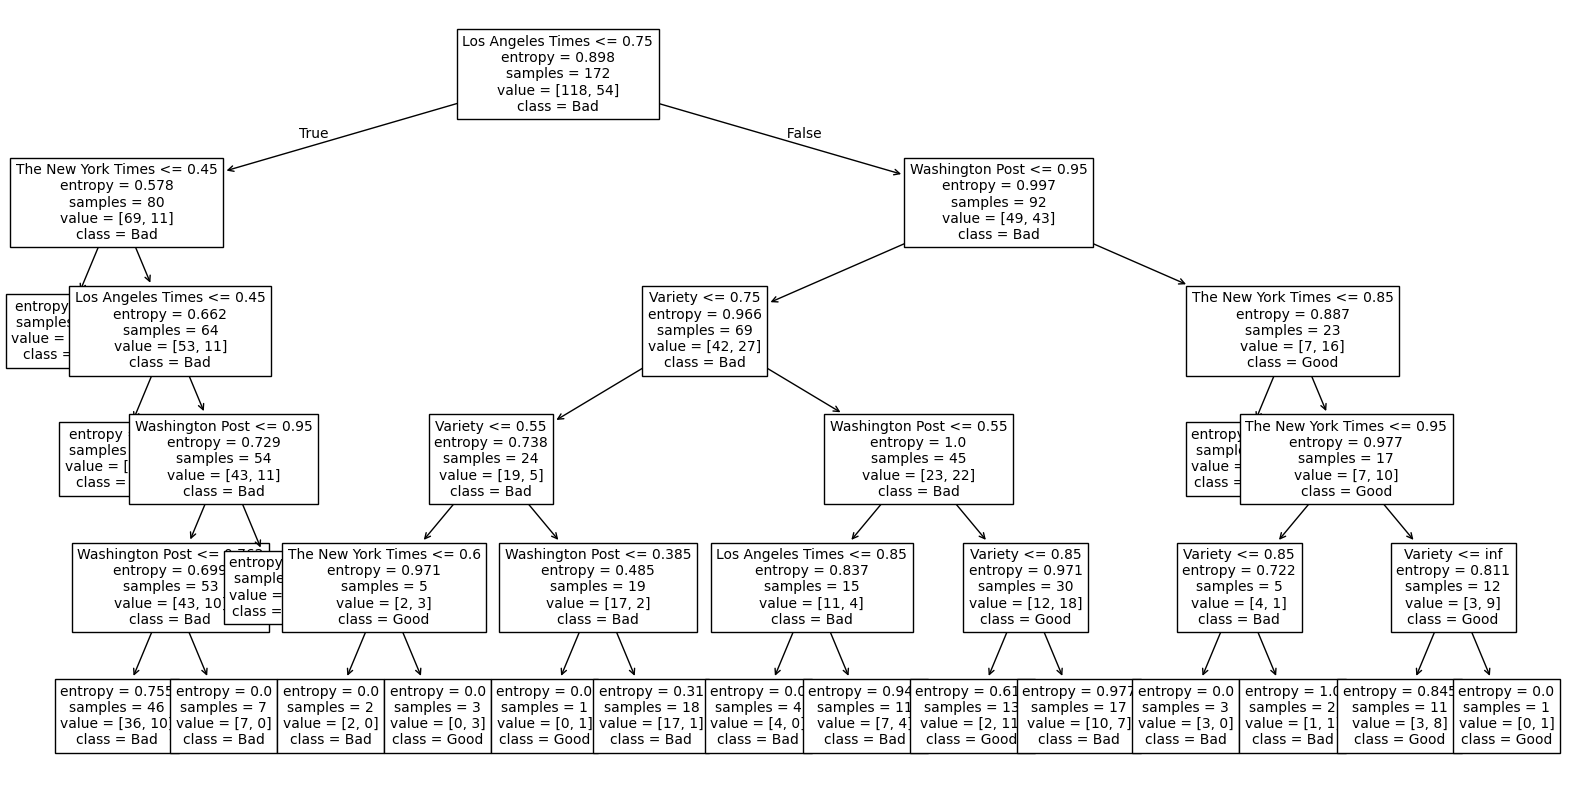

In [151]:
rip_a_tree(acr_df3, 'Washington Post, The New York Times, Variety, Los Angeles Times')

              precision    recall  f1-score   support

           0       0.77      0.72      0.74        32
           1       0.36      0.42      0.38        12

    accuracy                           0.64        44
   macro avg       0.56      0.57      0.56        44
weighted avg       0.65      0.64      0.64        44



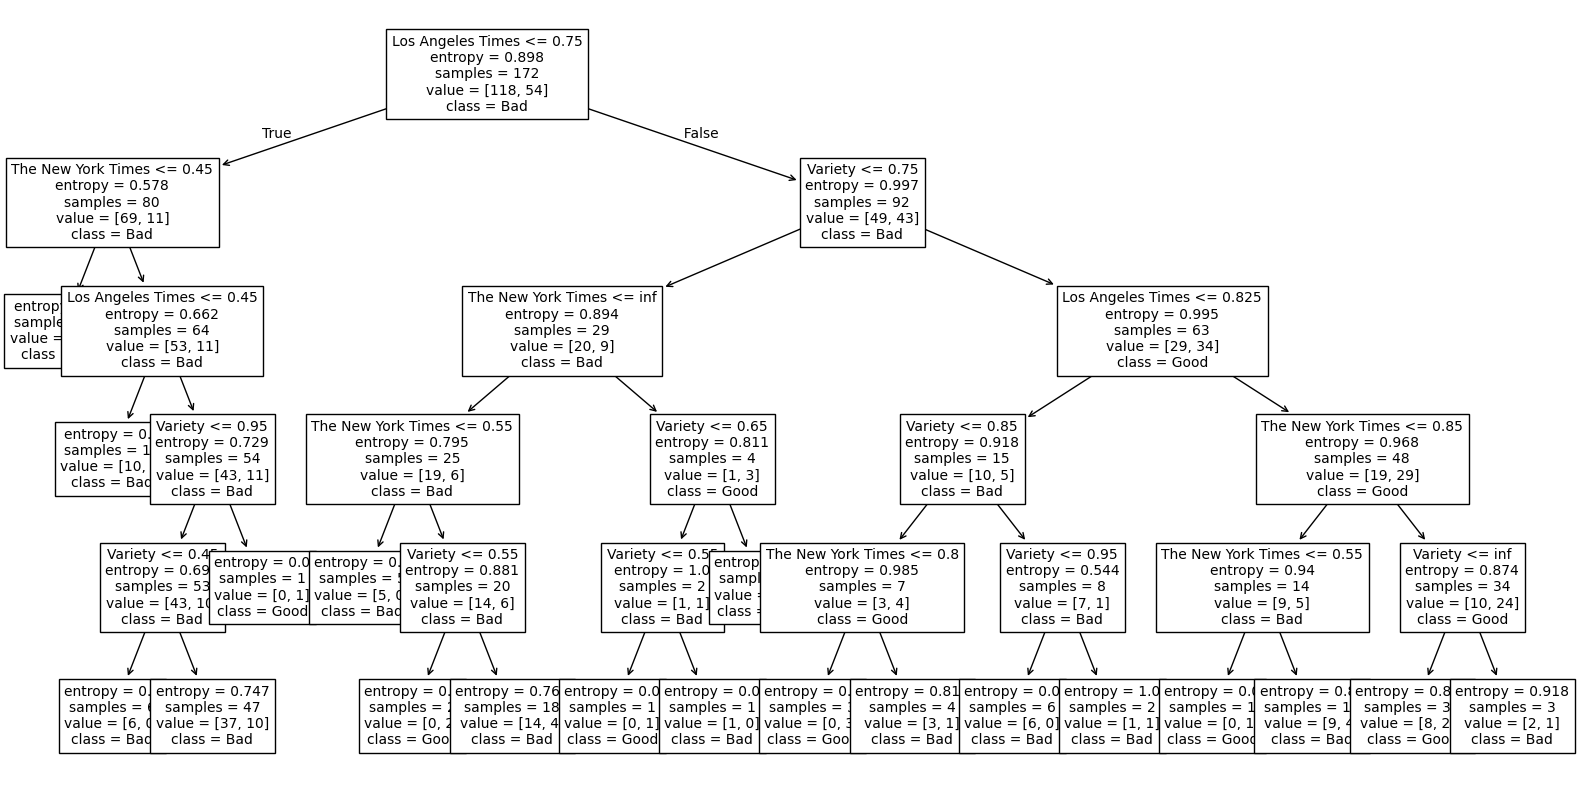

In [153]:
rip_a_tree(acr_df3, 'The New York Times, Variety, Los Angeles Times')